In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('~/code/patrickevans29/raw_data/final_player_dataset.csv')


In [21]:
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

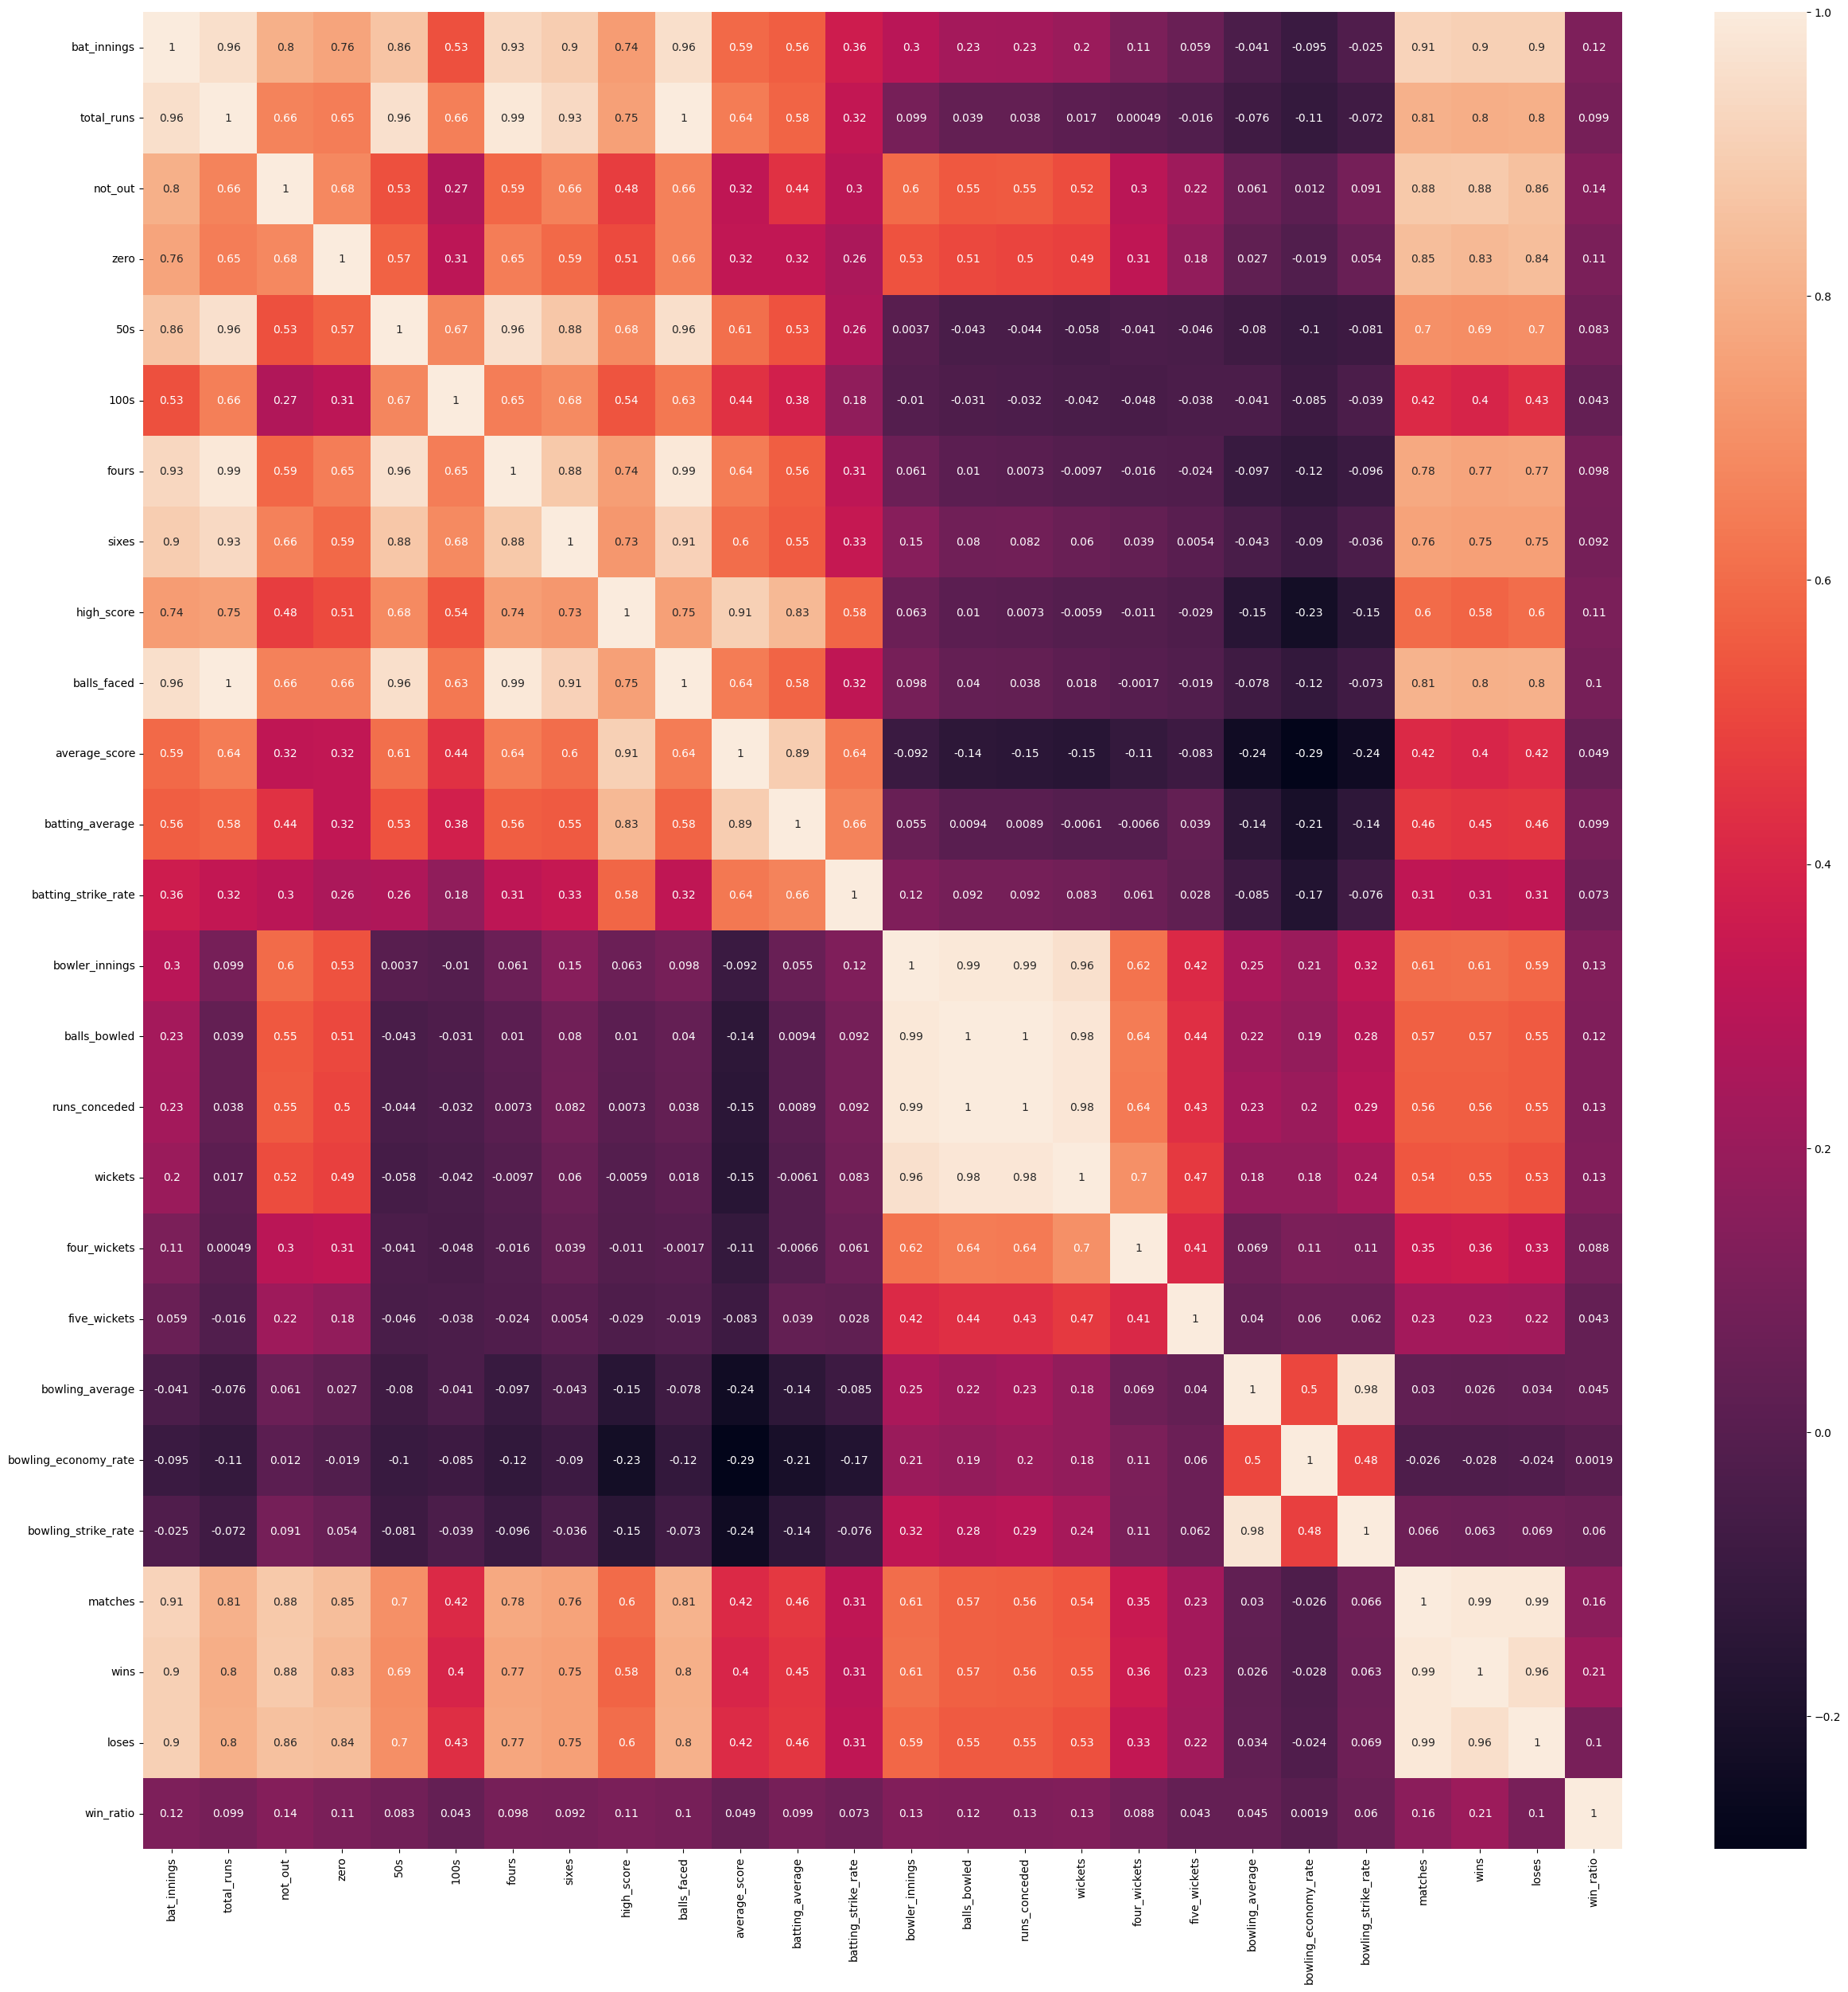

In [30]:
plt.figure(figsize=(30, 30))

sns.heatmap(numeric_columns.corr(), annot=True);

In [59]:
def player_batting_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Takes the ball by ball match cleaned dataframe as a base.
    Creates a dataframe of player batting features extracted from the
    ball by ball match dataframe.
    Returns the features processed.
    """
    assert isinstance(df, pd.DataFrame)

    df = df[PLAYER_PROCESSING_COLUMNS]

    ### Total Runs
    batter_total_runs = df.groupby(['batter'], as_index=False)['batsman_run']\
        .sum('batsman_run').rename(columns={'batsman_run': 'total_runs'})

    ### Balls Faced
    balls_faced = df[df['extra_type'].isin(['noextra', 'legbyes', 'byes', 'noballs'])]\
                .groupby(['batter'], as_index=False)['ballnumber'].count()\
                .rename(columns={'ballnumber': 'balls_faced'})

    ### Batter Innings
    batter_innings = df.groupby(['batter'], as_index=False)['ID'].nunique()\
                    .rename(columns={'ID': 'batter_innings'})
    non_striker_innings = df.groupby(['non_striker'], as_index=False)['ID'].nunique()\
                    .rename(columns={'ID': 'non_striker_innings', 'non_striker': 'batter'})
    combined_innings_df = batter_innings.merge(non_striker_innings, \
                    on='batter', how='outer').fillna(0)
    combined_innings_df['bat_innings'] = combined_innings_df[['batter_innings', 'non_striker_innings']].max(axis=1)
    bat_innings = combined_innings_df.drop(columns=['batter_innings', 'non_striker_innings'])

    ### Boundaries
    non_boundary = list(df[df['non_boundary'] == 1].index)
    temp_df = df.drop(index=non_boundary)
    fours = temp_df[temp_df['batsman_run'] == 4].groupby(['batter'], as_index=False)\
            ['batsman_run'].count().rename(columns={'batsman_run': 'fours'})
    sixes = temp_df[temp_df['batsman_run'] == 6].groupby(['batter'], as_index=False)\
            ['batsman_run'].count().rename(columns={'batsman_run': 'sixes'})

    ### Batsman Totals
    batsman_score_game = df.groupby(['ID', 'batter'], as_index=False)\
                        ['batsman_run'].sum().drop(columns='ID')
    fifty = batsman_score_game[batsman_score_game['batsman_run'] >= 50]\
        .groupby(['batter'], as_index=False).count().rename(columns={'batsman_run': '50s'})
    hundred = batsman_score_game[batsman_score_game['batsman_run'] >= 100]\
        .groupby(['batter'], as_index=False).count().rename(columns={'batsman_run': '100s'})
    merged_totals = fifty.merge(hundred, on='batter', how='outer').fillna(0)
    merged_totals['50s'] = merged_totals['50s'].sub(merged_totals['100s']).astype('int')
    merged_totals['100s'] = merged_totals['100s'].astype('int')

    ### Batsman Not Out
    last_ball_index_temp = list(df.groupby(['ID', 'innings'], as_index=False)['innings']\
                        .idxmax().sort_values(by='innings', ascending=False)['innings'])
    last_ball_index_temp.remove(0)
    last_ball_index = [index - 1 for index in last_ball_index_temp]
    last_ball_index.insert(0, df.shape[0])
    player_out_final_ball = df[(df['isWicketDelivery']==1) & (df.index.isin(last_ball_index))]\
                            .groupby(['player_out'], as_index=False)['ID'].count()\
                            .rename(columns={'ID': 'out_count', 'player_out': 'batter'})
    final_ball_batter = df[df.index.isin(last_ball_index)].groupby(['batter'], as_index=False)\
                        ['ID'].count().rename(columns={'ID': 'at_bat_count'})
    final_ball_non_striker = df[df.index.isin(last_ball_index)].groupby(['non_striker'], as_index=False)\
                            ['ID'].count().rename(columns={'ID': 'non_striker_count', 'non_striker': 'batter'})
    combined_final_ball = final_ball_batter.merge(final_ball_non_striker, on='batter', how='outer')\
                            .merge(player_out_final_ball, on='batter', how='outer')
    combined_final_ball.fillna(0, inplace=True)
    combined_final_ball['not_out'] = combined_final_ball['at_bat_count']\
                                    .add(combined_final_ball['non_striker_count'])\
                                    .sub(combined_final_ball['out_count']).astype('int')
    not_out = combined_final_ball[['batter', 'not_out']]

    ### High Score
    high_score = df.groupby(['ID', 'batter'], as_index=False)['batsman_run']\
                        .sum().groupby('batter', as_index=False)['batsman_run'].max()\
                        .rename(columns={'batsman_run': 'high_score'})

    ### Merge
    batting_stats_merged = bat_innings.merge(batter_total_runs, on='batter', how='outer')\
                        .merge(not_out, on='batter', how='outer')\
                        .merge(merged_totals, on='batter', how='outer')\
                        .merge(fours, on='batter', how='outer')\
                        .merge(sixes, on='batter', how='outer')\
                        .merge(high_score, on='batter', how='outer')\
                        .merge(balls_faced, on='batter', how='outer').fillna(0)

    ### Feature creation
    batting_stats_merged['average_score'] = round\
        ((batting_stats_merged['total_runs'] / batting_stats_merged['bat_innings']), 2).fillna(0)
    batting_stats_merged['batting_average'] = round((batting_stats_merged['total_runs'] / \
        (batting_stats_merged['bat_innings'] - batting_stats_merged['not_out'])), 2).fillna(0)
    batting_stats_merged['batting_average'] = np.where(batting_stats_merged\
        ['batting_average'] == np.inf, batting_stats_merged['average_score'], batting_stats_merged['batting_average'])
    batting_stats_merged['batting_strike_rate'] = round\
        ((batting_stats_merged['total_runs'] * 100)/batting_stats_merged['balls_faced'], 2).fillna(0)

    batting_stats_merged = batting_stats_merged.rename(columns={'batter': 'player'})

    print("✅ Batting Features Created")

    return batting_stats_merged


def player_bowling_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Takes the ball by ball match cleaned dataframe as a base.
    Creates a dataframe of player bowling features extracted from the
    ball by ball match dataframe.
    Returns the features processed.
    """
    assert isinstance(df, pd.DataFrame)

    df = df[PLAYER_PROCESSING_COLUMNS]

    ### Bowler Innings
    bowler_innings = df.groupby(['bowler'], as_index=False)['ID'].nunique()\
                    .rename(columns={'ID': 'bowler_innings'})

    ### Balls Bowled
    balls_bowled = df[df['extra_type'].isin(['noextra', 'legbyes', 'byes', 'penalty'])]\
                .groupby(['bowler'], as_index=False)['ballnumber'].count()\
                .rename(columns={'ballnumber': 'balls_bowled'})

    ### Runs Conceded
    runs_conceded = df[df['extra_type'].isin(['noextra', 'wides', 'noballs'])]\
                .groupby(['bowler'], as_index=False)['total_run'].sum()\
                .rename(columns={'total_run': 'runs_conceded'})

    ### Wickets Taken
    wickets = df[(df['isWicketDelivery'] == 1) & (df['kind'].isin\
                (['nokind', 'caught', 'caught and bowled', 'bowled','stumped', 'lbw', 'hit wicket']))]\
                .groupby(['bowler'], as_index=False)['isWicketDelivery'].count()\
                .rename(columns={'isWicketDelivery': 'wickets'})

    ### Wickets Per Game Stats
    wicket_count_per_game = df[(df['isWicketDelivery'] == 1) & (df['kind'].isin\
                (['nokind', 'caught', 'caught and bowled', 'bowled','stumped', 'lbw', 'hit wicket']))]\
                .groupby(['ID', 'bowler'], as_index=False)['isWicketDelivery'].count()\
                .rename(columns={'isWicketDelivery': 'wickets'})

    four_wickets = wicket_count_per_game[wicket_count_per_game['wickets'] == 4]\
                .groupby(['bowler'], as_index=False)['wickets'].count()\
                .rename(columns={'wickets': 'four_wickets'})

    five_wickets = wicket_count_per_game[wicket_count_per_game['wickets'] == 5]\
                .groupby(['bowler'], as_index=False)['wickets'].count()\
                .rename(columns={'wickets': 'five_wickets'})

    ### Merge
    bowling_stats_merged = bowler_innings.merge(balls_bowled, on='bowler', how='outer')\
                        .merge(runs_conceded, on='bowler', how='outer')\
                        .merge(wickets, on='bowler', how='outer')\
                        .merge(four_wickets, on='bowler', how='outer')\
                        .merge(five_wickets, on='bowler', how='outer').fillna(0)

    ### Feature Creation
    bowling_stats_merged['bowling_average'] = round\
        ((bowling_stats_merged['runs_conceded'] / bowling_stats_merged['wickets']), 2).fillna(0)
    bowling_stats_merged['bowling_average'] = np.where\
        (bowling_stats_merged['bowling_average'] == np.inf, 0, bowling_stats_merged['bowling_average'])
    bowling_stats_merged['bowling_economy_rate'] = round\
        ((bowling_stats_merged['runs_conceded']/(bowling_stats_merged['balls_bowled'] / 6)), 2)
    bowling_stats_merged['bowling_strike_rate'] = round((bowling_stats_merged['balls_bowled']/bowling_stats_merged['wickets']), 2)
    bowling_stats_merged['bowling_strike_rate'] = np.where\
        (bowling_stats_merged['bowling_strike_rate'] == np.inf, 0, bowling_stats_merged['bowling_strike_rate'])

    bowling_stats_merged = bowling_stats_merged.rename(columns={'bowler': 'player'})

    print("✅ Bowling Features Created")

    return bowling_stats_merged


def win_loss_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Takes a cleaned dataframe as a base.
    Creates a dataframe of player win loss statistics.
    Returns the features processed.
    """
    assert isinstance(df, pd.DataFrame)
    assert isinstance(df['Team1Players'][0], list)

    df = df[WIN_LOSS_PROCESSING_COLUMNS]

    ### Group to remove duplicates
    df = df.groupby('ID', as_index=False).first()

    ### Team 1 Wins
    def team_1_wins(Team1, Team2, WinningTeam):
        if WinningTeam == Team1:
            return 1
        elif WinningTeam == Team2:
            return 0
        else:
            return -1

    df['team_1_win'] = df.apply(lambda row: \
        team_1_wins(row['Team1'], row['Team2'], row['WinningTeam']), axis=1)

    ### Winning Player Count
    def winning_team_players(team_1_win, Team1Players, Team2Players):
        if team_1_win == 1:
            return Team1Players
        elif team_1_win == 0:
            return Team2Players
        else:
            return []

    df['winning_team_players'] = df.apply(lambda row: winning_team_players\
        (row['team_1_win'], row['Team1Players'], row['Team2Players']), axis=1)

    player_wins = []
    def player_wins_list(winning_team_players):
        for row in winning_team_players:
            for player in row:
                player_wins.append(player)
        return player_wins

    player_wins_list(df['winning_team_players'])

    player_win_count = {}
    for player in player_wins:
        if player in player_win_count:
            player_win_count[player] += 1
        else:
            player_win_count[player] = 1

    wins = pd.DataFrame({'player': player_win_count.keys(), \
                        'wins': player_win_count.values()})

    ### Losing Player Count
    def losing_team_players(team_1_win, Team1Players, Team2Players):
        if team_1_win == 0:
            return Team1Players
        elif team_1_win == 1:
            return Team2Players
        else:
            return []

    df['losing_team_players'] = df.apply(lambda row: losing_team_players\
        (row['team_1_win'], row['Team1Players'], row['Team2Players']), axis=1)

    player_loses = []
    def player_loses_list(losing_team_players):
        for row in losing_team_players:
            for player in row:
                player_loses.append(player)
        return player_loses

    player_loses_list(df['losing_team_players'])

    player_loss_count = {}
    for player in player_loses:
        if player in player_loss_count:
            player_loss_count[player] += 1
        else:
            player_loss_count[player] = 1

    loses = pd.DataFrame({'player': player_loss_count.keys(), \
                            'loses': player_loss_count.values()})

    ### Matches
    matches = {}

    for player in player_win_count:
        if player in player_loss_count:
            matches[player] = player_win_count[player] + player_loss_count[player]
        elif player not in player_loss_count:
            matches[player] = player_win_count[player]

    for player in player_loss_count:
        if player not in player_win_count:
            matches[player] = player_loss_count[player]

    matches = pd.DataFrame({'player': matches.keys(), \
                            'matches': matches.values()})

    ### Merge
    win_loss_merge = matches.merge(wins, on='player', how='outer')\
                        .merge(loses, on='player', how='outer').fillna(0)

    ### Create Win Ratio
    win_loss_merge['win_ratio'] = \
        round((win_loss_merge['wins']/win_loss_merge['matches']), 2)

    print("✅ Win Loss Features Created")

    return win_loss_merge


def player_features_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """
    Takes a cleaned dataframe as a base.
    Compiles the final player dataset.
    """
    assert isinstance(df, pd.DataFrame)

    batting = player_batting_features(df)
    bowling = player_bowling_features(df)
    win_loss = win_loss_features(df)

    final_player_dataset = batting.merge(bowling, on='player', how='outer')\
                            .merge(win_loss, on='player', how='outer').fillna(0)

    print("✅ Final Player Dataset Created")

    return final_player_dataset


In [41]:
PLAYER_PROCESSING_COLUMNS = ['ID', 'innings', 'overs', 'ballnumber', 'batter',
        'bowler', 'non_striker', 'extra_type', 'batsman_run', 'extras_run',
        'total_run', 'non_boundary', 'isWicketDelivery', 'player_out', 'kind',
        'fielders_involved', 'BattingTeam']

WIN_LOSS_PROCESSING_COLUMNS = ['ID', 'Season', 'Team1', 'Team2', 'WinningTeam',
                             'Player_of_Match', 'Team1Players', 'Team2Players']

In [43]:
df2 = pd.read_csv('~/code/patrickevans29/raw_data/complete_cleaned_dataset.csv', converters={'Team1Players': pd.eval, 'Team2Players':pd.eval})

In [54]:
type(df2['Team1Players'][0])

list

In [65]:
df2.columns

Index(['ID', 'innings', 'overs', 'ballnumber', 'batter', 'bowler',
       'non_striker', 'extra_type', 'batsman_run', 'extras_run', 'total_run',
       'non_boundary', 'isWicketDelivery', 'player_out', 'kind',
       'fielders_involved', 'BattingTeam', 'City', 'Date', 'Season',
       'MatchNumber', 'Team1', 'Team2', 'Venue', 'TossWinner', 'TossDecision',
       'SuperOver', 'WinningTeam', 'WonBy', 'Margin', 'Player_of_Match',
       'Team1Players', 'Team2Players', 'Umpire1', 'Umpire2'],
      dtype='object')

In [66]:
df3 = player_features_dataset(df2[df2['Season'] == 2022])

✅ Batting Features Created
✅ Bowling Features Created
✅ Win Loss Features Created
✅ Final Player Dataset Created


In [67]:
df3

,player,bat_innings,total_runs,not_out,50s,100s,fours,sixes,high_score,balls_faced,...,wickets,four_wickets,five_wickets,bowling_average,bowling_economy_rate,bowling_strike_rate,matches,wins,loses,win_ratio
0,a badoni,11.0,161.0,3.0,1.0,0.0,11.0,7.0,54.0,130.0,...,2.0,0.0,0.0,5.50,5.50,6.00,13,8.0,5.0,0.62
1,a manohar,7.0,108.0,1.0,0.0,0.0,14.0,3.0,43.0,75.0,...,0.0,0.0,0.0,0.00,0.00,0.00,8,7.0,1.0,0.88
2,a nortje,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,...,9.0,0.0,0.0,24.11,9.72,14.89,6,3.0,3.0,0.50
3,a tomar,1.0,4.0,0.0,0.0,0.0,1.0,0.0,4.0,8.0,...,0.0,0.0,0.0,0.00,0.00,0.00,1,0.0,1.0,0.00
4,abdul samad,2.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,7.0,...,0.0,0.0,0.0,0.00,8.00,0.00,2,0.0,2.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,s kaul,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,10.75,0.00,1,1.0,0.0,1.00
186,sandeep sharma,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,76.50,7.65,60.00,5,3.0,2.0,0.60
187,t natarajan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,0.0,0.0,22.56,9.44,14.33,11,6.0,5.0,0.55
188,tu deshpande,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,63.00,9.00,42.00,2,0.0,2.0,0.00


In [68]:
numeric_columns2 = df3.select_dtypes(include=['int64', 'float64'])

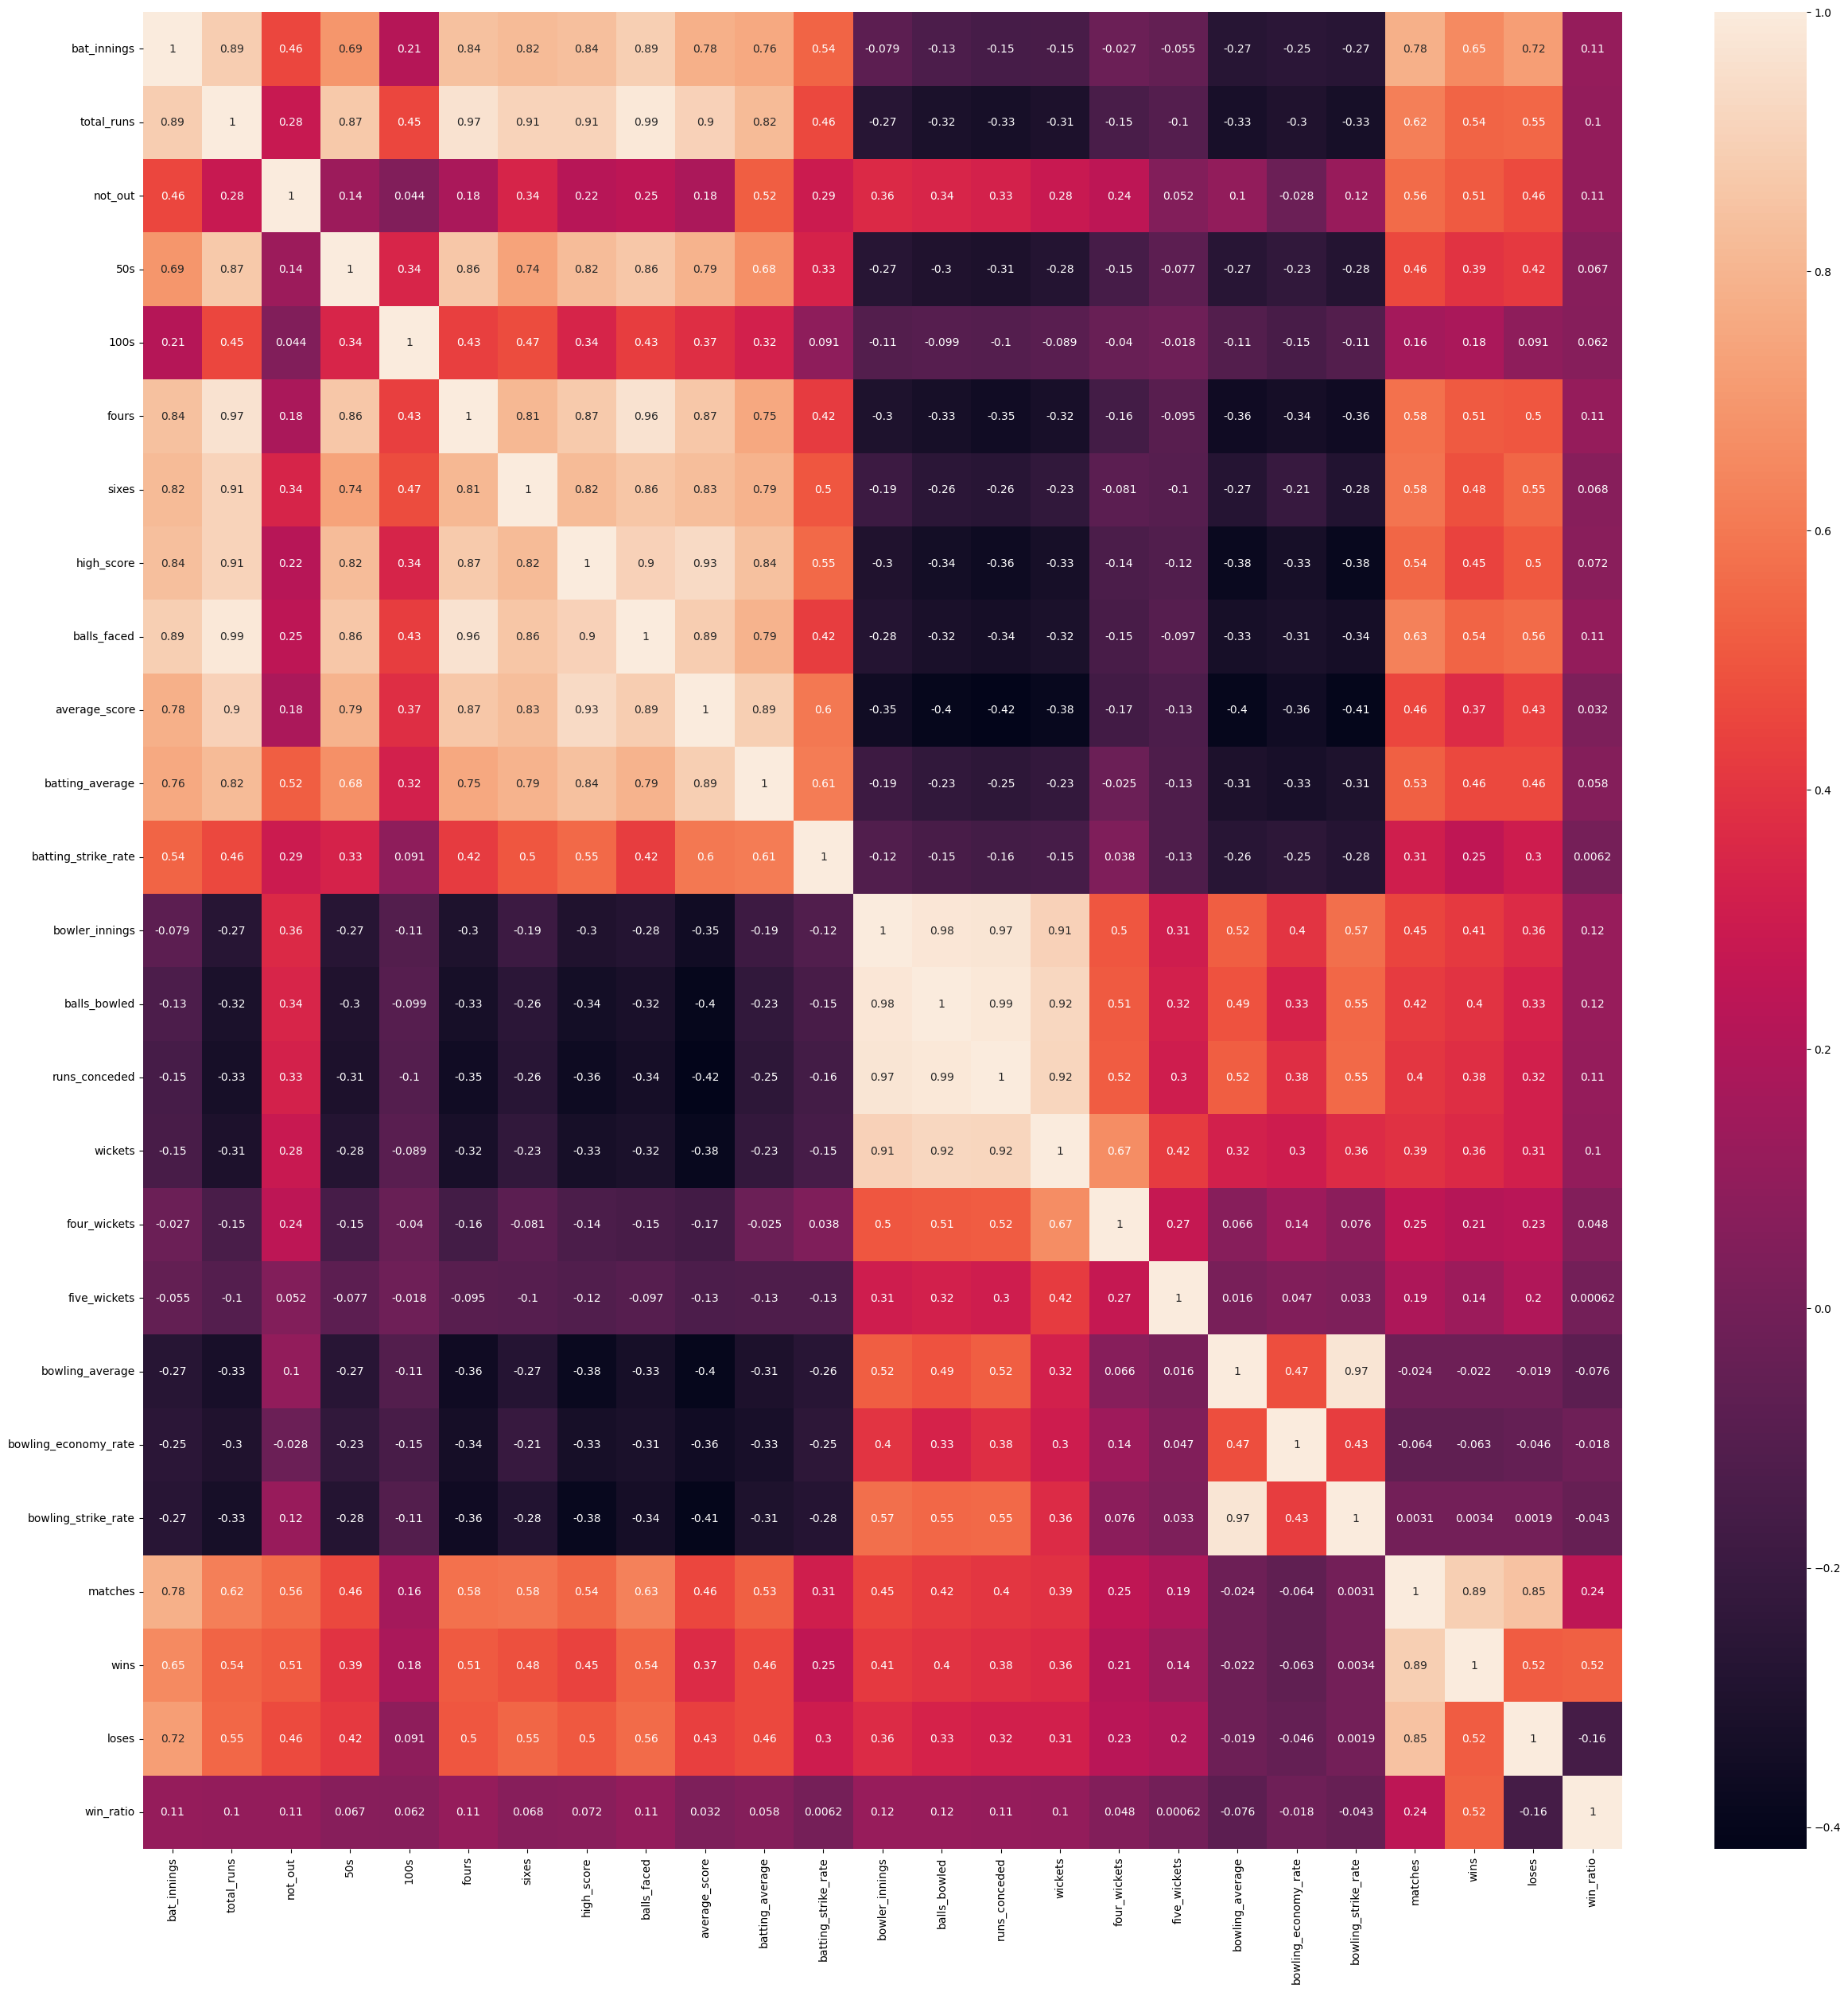

In [69]:
plt.figure(figsize=(30, 30))

sns.heatmap(numeric_columns2.corr(), annot=True);

In [70]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Clean data by:
    - Removing or imputing NaN
    '''
    ## cleaning data from ball_by_ball dataframe
    # drop duplicates
    df = df.drop_duplicates()
    # assign the good value to overs
    df["overs"] = df["overs"] + 1
    # cleaning the string values
    # batter
    df["batter"] = [text.strip() for text in df["batter"]] # removing space
    df["batter"] = [text.lower() for text in df["batter"]] # lowercase
    # bowler
    df["bowler"] = [text.strip() for text in df["bowler"]]
    df["bowler"] = [text.lower() for text in df["bowler"]]
    # non-striker
    df.rename(columns={"non-striker": "non_striker"}, inplace=True) #renaming the non_striker
    df["non_striker"] = [text.strip() for text in df["non_striker"]]
    df["non_striker"] = [text.lower() for text in df["non_striker"]]
    # extra-types
    df["extra_type"] = df["extra_type"].fillna("noextra") # filling the NaN values
    # player out
    df["player_out"] = df["player_out"].fillna("noplayerout") # filling the NaN values
    df["player_out"] = [text.strip() for text in df["player_out"]]
    df["player_out"] = [text.lower() for text in df["player_out"]]
    # kind
    df["kind"] = df["kind"].fillna("nokind") # filling the NaN values
    df["kind"] = [text.strip() for text in df["kind"]]
    df["kind"] = [text.lower() for text in df["kind"]]
    # fielders involved
    df["fielders_involved"] = df["fielders_involved"].fillna("nofieldersinvolved") ## filling the NaN values
    df["fielders_involved"] = [text.strip() for text in df["fielders_involved"]]
    df["fielders_involved"] = [text.lower() for text in df["fielders_involved"]]
    # batting team
    df["BattingTeam"] = [text.strip() for text in df["BattingTeam"]]
    df["BattingTeam"] = [text.lower() for text in df["BattingTeam"]]
    # some teams change their name since 2008
    team_name_dict = {'rising pune supergiants': 'rising pune supergiant',
                  'kings xi punjab': 'punjab kings',
                  'delhi daredevils': 'delhi capitals'}
    df['BattingTeam'] = df['BattingTeam'].replace(team_name_dict)

    ## cleaning data from match dataframe
    # Adding the correct City for the matching Venue
    df.loc[df.Venue == 'Dubai International Cricket Stadium','City'] = 'Dubai'
    df.loc[df.Venue == 'Sharjah Cricket Stadium','City'] = 'Sharjah'
    # Creating a dictionary of duplicated Venues so only one entry is created for each venue
    venues_dict = {'Arun Jaitley Stadium, Delhi': 'Arun Jaitley Stadium',
                'Brabourne Stadium, Mumbai': 'Brabourne Stadium',
                'Dr DY Patil Sports Academy, Mumbai': 'Dr DY Patil Sports Academy',
                'Eden Gardens, Kolkata': 'Eden Gardens',
                'M Chinnaswamy Stadium': 'M.Chinnaswamy Stadium',
                'MA Chidambaram Stadium, Chepauk': 'MA Chidambaram Stadium',
                'MA Chidambaram Stadium, Chepauk, Chennai': 'MA Chidambaram Stadium',
                'Maharashtra Cricket Association Stadium, Pune': 'Maharashtra Cricket Association Stadium',
                'Punjab Cricket Association IS Bindra Stadium, Mohali': 'Punjab Cricket Association IS Bindra Stadium',
                'Punjab Cricket Association Stadium, Mohali': 'Punjab Cricket Association IS Bindra Stadium',
                'Rajiv Gandhi International Stadium, Uppal': 'Rajiv Gandhi International Stadium',
                'Wankhede Stadium, Mumbai': 'Wankhede Stadium',
                'Zayed Cricket Stadium, Abu Dhabi': 'Sheikh Zayed Stadium'}
    df['Venue'] = df['Venue'].replace(venues_dict)
    # Two teams have changed their name over the period the dataset covers
    team_name_changes = {'Kings XI Punjab': 'Punjab Kings',
                        'Delhi Daredevils': 'Delhi Capitals'}
    df['Team1'] = df['Team1'].replace(team_name_changes)
    # Updating the team name for Rising Pune Supergiant
    team_name_dict = {'Rising Pune Supergiants': 'Rising Pune Supergiant'}
    df['Team1'] = df['Team1'].replace(team_name_dict)
    # Updating the other team name columns
    df['Team2'] = df['Team2'].replace(team_name_changes)
    df['TossWinner'] = df['TossWinner'].replace(team_name_changes)
    df['WinningTeam'] = df['WinningTeam'].replace(team_name_changes)
    df['Team2'] = df['Team2'].replace(team_name_dict)
    df['TossWinner'] = df['TossWinner'].replace(team_name_dict)
    df['WinningTeam'] = df['WinningTeam'].replace(team_name_dict)
    # Identifying and removing 4 "NoResult" Values
    df['WinningTeam'] = df['WinningTeam'].fillna('NoResults')
    df['Player_of_Match'] = df['Player_of_Match'].fillna('NoResults')
    df['SuperOver'] = df['SuperOver'].fillna('NoResults')
    df.loc[df['WinningTeam'].isna(), 'method'] = 'NoResults'
    df.loc[df['WinningTeam'].isna(), 'Margin'] = 0
    # The method column held no useful information and was dropped
    df = df.drop(columns='method')
    # Results from margin related to Superover and have been filled with 0
    df['Margin'] = df['Margin'].fillna(0)

    # Updating dates so we are able to identify seasonal changes in data
    season_dict = {'2020/21': '2020',
                '2009/10': '2010',
                '2007/08': '2008'}

    df['Season'] = df['Season'].replace(season_dict)
    # Selecting columns to strip
    df_columns = list(df.select_dtypes(include='object').columns)
    # Stripping the data for each column
    for column in df_columns:
        df[column] = [text.strip().lower() for text in df[column]]

    print("✅ data cleaned")
    return df


def feature_engineer(df: pd.DataFrame) -> pd.DataFrame:
    '''
    This is where we create the new features for the model.
    They should be:
    - team_1_win --> 1 or 0 if team 1 one the match
    - innings_total --> to be used to calculate batting avgs etc.
    - team_1_batting_average --> the average amount of runs that team1 scores in a match
    - team_2_batting_average --> the average amount of runs that team2 scores in a match
    - team_1_toss_winner --> 1 or 0 if team1 won the toss
    - match_importance --> ordinal value given to the importance of the match. Final or regular etc.
    - team_1_points_against_avg --> the average number of point opposition teams score agains team_1
    - team_2_points_against_avg --> the average number of point opposition teams score agains team_2
    - team_1_avg_mvp --> average number of times that team_1 has MVP
    - team_2_avg_mvp --> average number of times that team_2 has MVP
    '''
    # create the binary column Team1_Win
    df['Team1_Win'] = (df['Team1'] == df['WinningTeam']).astype(int)
    # create the innings total
    df['innings_total'] = df.groupby(['ID', 'innings'])['total_run'].transform('sum')
    df = df[(df['innings'] == 1) | (df['innings'] == 2)]
    # Convert the innings totals into columns

    # Group by 'ID' and 'innings' and calculate innings_total
    innings_totals = df.groupby(['ID', 'innings'])['innings_total'].mean().unstack()
    innings_totals.columns = ['Team1_innings_total', 'Team2_innings_total']

    # Merge the innings_totals DataFrame back into new_df on 'ID'
    df = pd.merge(df, innings_totals, left_on='ID', right_index=True)
    df['team_batting_average'] = df.groupby('BattingTeam')['total_run'].transform('sum') / df.groupby('BattingTeam')['ID'].transform('nunique')
    # Extract the relevant columns
    selected_columns = ['ID', 'innings', 'Team1', 'Team2', 'team_batting_average', 'MatchNumber','WinningTeam', 'innings_total', 'City', 'Date', 'Venue', 'TossWinner', 'TossDecision', 'Team1Players', 'Team2Players']
    new_df = df[selected_columns].copy()
    new_df.head()

    # Filter innings 1 (Team1's innings)
    team_a_data = new_df[new_df['innings'] == 1][['ID','Team1', 'team_batting_average' ]]
    team_a_data.rename(columns={'team_batting_average': 'Team_1_batting_average'}, inplace=True)

    # Filter innings 2 (Team1's innings)
    team_b_data = new_df[new_df['innings'] == 2][['ID', 'Team2', 'team_batting_average']]
    team_b_data.rename(columns={'team_batting_average': 'Team_2_batting_average'}, inplace=True)

    # Merge the data from innings 1 and innings 2 for each match ID
    merged_data = pd.merge(team_a_data, team_b_data, on='ID')
    # Drop duplicates based on 'ID' column and keep the first occurrence
    final_data = merged_data.drop_duplicates(subset='ID', keep='first')
    # Reset the index
    final_data.reset_index(drop=True, inplace=True)
    # drop the duplicate columns
    final_data.drop(columns=["Team1", "Team2"], inplace=True)
    # merge with the main df
    df = pd.merge(df, final_data, on = "ID")
    # drop the useless column
    df.drop(columns=['team_batting_average'], inplace=True)
    # new binary column for the toss winner
    df['team_1_toss_winner'] = (df['Team1'] == df['TossWinner']).astype(int)

    # Apply the function
    df['MatchImportance'] = df['MatchNumber'].apply(map_match_number)
    # Calculate the average points scored against a each team
    df['Team1_points_against_avg'] = df.groupby('Team1')['Team2_innings_total'].transform('mean')
    df['Team2_points_against_avg'] = df.groupby('Team2')['Team1_innings_total'].transform('mean')
    # Calculate the average number of times that team_1 has MVP

    df['Team_MVP'] = df.apply(lambda row: get_match_winner(row['Player_of_Match'], row['Team1Players'], row['Team2Players']), axis=1)

    df['Team_MVP'] = df.apply(replace_team_mvp_with_name, axis=1)
    team_mvp_counts = df['Team_MVP'].value_counts().reset_index()

    team_mvp_counts.columns = ['Team_MVP', 'MVP_Count']

    # Create the columns Team1_MVP_appearances e Team2_MVP_appearances
    df = df.merge(team_mvp_counts, left_on='Team1', right_on='Team_MVP', how='left').fillna(0)
    df.rename(columns={'MVP_Count': 'Team1_MVP_appearances'}, inplace=True)

    df = df.merge(team_mvp_counts, left_on='Team2', right_on='Team_MVP', how='left').fillna(0)
    df.rename(columns={'MVP_Count': 'Team2_MVP_appearances'}, inplace=True)

    # Drop columns
    df.drop(['Team_MVP_x', 'Team_MVP_y', 'Team_MVP'], axis=1, inplace=True)

    # Now, let's create the average of MVP appearences
    total_games_team1 = df['Team1'].value_counts()
    total_games_team2 = df['Team2'].value_counts()

    total_games = total_games_team2 + total_games_team1

    df['Team1_MVP_average'] = df['Team1_MVP_appearances'] / total_games[df['Team1']].values
    df['Team2_MVP_average'] = df['Team2_MVP_appearances'] / total_games[df['Team2']].values
    df = df.drop(columns = ['Team1_MVP_appearances', 'Team2_MVP_appearances'])

    df = clean_data(df)

    return df

In [73]:
df_match = pd.read_csv('~/code/patrickevans29/raw_data/IPL_Matches_2008_2022.csv')
df_ball = pd.read_csv('~/code/patrickevans29/raw_data/IPL_Ball_by_Ball_2008_2022.csv')

In [75]:
df4 = df_match.merge(df_ball, on='ID', how='outer')

In [77]:
df5 = clean_data(df4)

✅ data cleaned


In [81]:
df6 = feature_engineer(df5)

/var/folders/4n/3hw1gckd4zg3786ftn8gpp8c0000gn/T/ipykernel_11451/2351352032.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data.drop(columns=["Team1", "Team2"], inplace=True)
/var/folders/4n/3hw1gckd4zg3786ftn8gpp8c0000gn/T/ipykernel_11451/2351352032.py:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NoResults' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['WinningTeam'].isna(), 'method'] = 'NoResults'


✅ data cleaned


In [80]:
def map_match_number(value):
            if isinstance(value, int) or value.isnumeric():
                return 1
            elif value in ['qualifier 2', 'eliminator', 'qualifier 1', 'qualifier', 'elimination final', '3rd place play-off', 'semi final']:
                return 2
            elif value == 'final':
                return 3
            else:
                return 0

def get_match_winner(player_of_match, team1_players, team2_players):
            if pd.isna(player_of_match):
                return 'N/A'

            if pd.isna(team1_players):
                team1_players = []

            if pd.isna(team2_players):
                team2_players = []

            if player_of_match in team1_players:
                return 'Team1'
            elif player_of_match in team2_players:
                return 'Team2'
            else:
                return 'N/A'

def replace_team_mvp_with_name(row):
            if row['Team_MVP'] == 'Team1':
                return row['Team1']
            elif row['Team_MVP'] == 'Team2':
                return row['Team2']
            else:
                return row['Team_MVP']